# Variable 클래스 구현

In [1]:
import numpy as np

In [2]:
class Variable:
    def __init__(self, data):
        self.data = data

In [3]:
data = np.array(1.0)
x = Variable(data)
print(x.data)

1.0


class를 사용하는 이유?
- 변수를 담기도 해야하고
- 함수를 선언해서 사용해야 하기도하고
- 다른 코드에 영향을 받을 확률이 낮아짐

In [20]:
def sum(num1, num2):
    return num1+num2

def subtract(num1, num2):
    return num1 - num2
n1 = 20
n2 = 10
print(sum(n1, n2))
print(subtract(n1, n2))

n3 = 40
n4 = 30
print(sum(n4, n3))
print(subtract(n4, n3))

30
10
70
-10


In [21]:
class Calc(object):
    def __init__(self, num1, num2):
        self.num1 = num1
        self.num2 = num2
 
    def sum(self):
         return self.num1 + self.num2
 
    def sub(self):
         return self.num1 - self.num2
 
C1 = Calc(20,10)
print(C1.sum())
print(C1.sub())
C2 = Calc(40,20)
print(C1.sum())
print(C1.sub())

30
10
30
10


기본적인 데이터 구조는 '다차원 배열'을 사용한다.

그래서 클래스는 "무조건" numpy의 다차원 배열만 취급해야함!

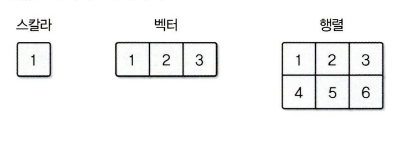

- 원소의 순서에는 방향이 있고 이 방향을 **차원** , **축**이라고 한다.
- 다차원 배열을 텐서라고도 한다. 0차원 텐서, 1차원 텐서, 2차원 텐서

In [22]:
x = np.array([1, 2, 3])
x.ndim

1

In [23]:
x = np.array([[1, 2, 3],
             [4, 5, 6]])
x.ndim

2

벡터를 다룰 때 "차원"이라는 말에 주의해야 합니다. 예로 ```x = np.array([1, 2, 3])```는 3개의 요소가 일렬로 늘어서 있기 때문에, '3차원 벡터'라고도 한다. 이때 '벡터의 차원'은 벡터의 원소수를 말합니다. 

In [24]:
class Function:
    def __call__(self, input):
        x = input.data # 데이터를 꺼낸다
        y = x ** 2 # 계산
        output = Variable(y) # Variable 형태로 되돌린다.
        return output

In [25]:
x = Variable(np.array(10))
f = Function()
y = f(x)

print(type(y)) # type() 함수는 객체의 클래스를 알려준다.
print(y.data)

<class '__main__.Variable'>
100


In [26]:
class Function:
    def __call__(self, input):
        x = input.data # 데이터를 꺼낸다
        y = self.forward(x) # 계산
        output = Variable(y) # Variable 형태로 되돌린다.
        return output
    
    def forward(self, x):
        raise NotImplementedError()

In [27]:
class Square(Function):
    def forward(self, x):
        return x ** 2

In [28]:
x = Variable(np.array(10))
f = Square()
y = f(x)
print(type(y))
print(y.data)

<class '__main__.Variable'>
100


In [29]:
class Exp(Function):
    def forward(self, x):
        return np.exp(x)

In [30]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)
print(y.data)
print(type(y))

1.648721270700128
<class '__main__.Variable'>


# 수치미분
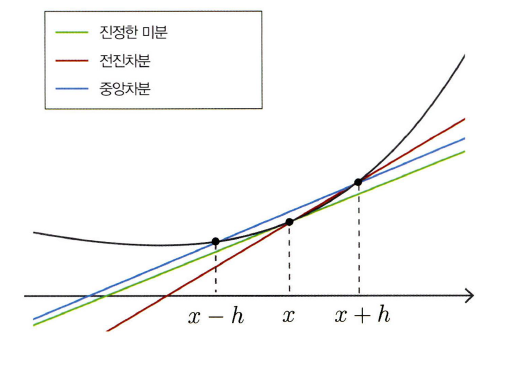

In [33]:
def numerical_diff(f, x, eps=1e-4):
    x0 = Variable(x.data - eps)
    x1 = Variable(x.data + eps)
    y0 = f(x0)
    y1 = f(x1)
    return (y1.data - y0.data) / (2 * eps)

In [34]:
# y = x ^ 2 
# x = 2.0 -> dy/dx = 4
f = Square()
x = Variable(np.array(2.0))
dy = numerical_diff(f, x)
print(dy)

4.000000000004


In [45]:
def f(x):
    A = Square()
    B = Exp()
    C = Square()
    return C(B(A(x)))

x = Variable(np.array(0.5))
dy = numerical_diff(f, x)
print(dy)

3.2974426293330694


# 역전파 수동
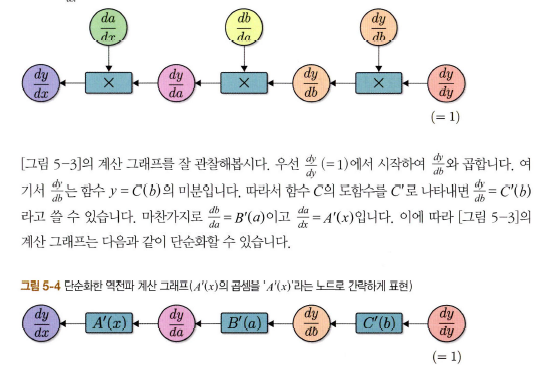
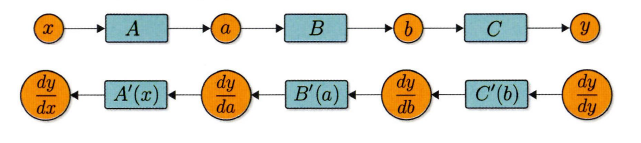

In [39]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None

In [40]:
class Function:
    def __call__(self, input):
        x = input.data # 데이터를 꺼낸다
        y = self.forward(x) # 계산
        output = Variable(y) # Variable 형태로 되돌린다.
        self.input = input # 입력 변수를 기억(보관)한다.
        return output
    
    def forward(self, x):
        raise NotImplementedError()
        
    def backward(self, gy):
        raise NotImplementedError()

In [78]:
class Sqare(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx

In [79]:
class Exp(Function):
    def forward(self, x):
        y = np.exp(x)
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx

In [43]:
A = Sqare()
B = Exp()
C = Sqare()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

In [44]:
y.grad = np.array(1.0)
b.grad = C.backward(y.grad)
a.grad = B.backward(b.grad)
x.grad = A.backward(a.grad)
print(x.grad)

3.297442541400256


# 역전파 자동

In [80]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None
        
    def set_creator(self, func):
        self.creator = func

In [91]:
class Function:
    def __call__(self, input):
        x = input.data # 데이터를 꺼낸다
        y = self.forward(x) # 계산
        output = Variable(y) # Variable 형태로 되돌린다.
        output.set_creator(self) # 출력 변수에 창조자를 설정한다.
        self.input = input # 입력 변수를 기억(보관)한다.
        self.output = output # 출력도 저장한다.
        return output
    
    def forward(self, x):
        raise NotImplementedError()
        
    def backward(self, gy):
        raise NotImplementedError()

In [57]:
A = Sqare()
B = Exp()
C = Sqare()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

# 계산 그래프의 노드들을 거꾸로 거슬러 올라간다.
assert y.creator == C
assert y.creator.input == b
assert y.creator.input.creator == B
assert y.creator.input.creator.input == a
assert y.creator.input.creator.input.creator == A
assert y.creator.input.creator.input.creator.input == x

In [60]:
y.grad = np.array(1.0)

C = y.creator # 1. 함수를 가져온다.
b = C.input # 2. 함수의 입력을 가져온다.
b.grad = C.backward(y.grad) # 3. 함수의 backward 메서드를 호출한다

B = b.creator # 1. 함수를 가져온다.
a = B.input # 2. 함수의 입력을 가져온다.
a.grad = B.backward(b.grad) # 3. 함수의 backward 메서드를 호출한다

A = a.creator # 1. 함수를 가져온다.
x = C.input # 2. 함수의 입력을 가져온다.
x.grad = A.backward(a.grad) # 3. 함수의 backward 메서드를 호출한다

print(x.grad)

3.297442541400256


# 메서드에 추가

In [82]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None
        
    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        f = self.creator
        if f is not None:
            x = f.input # 함수의 입력을 가져온다.
            x.grad = f.backward(self.grad) # 함수의 backward 메서드를 호출한다.
            x.backward() # 하나 앞 변수의 backward 메서드를 호출한다(재귀).

In [83]:
A = Sqare()
B = Exp()
C = Sqare()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

# 역전파
y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


# 재귀가 아닌 반복문으로

In [92]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None
        
    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            x, y = f.input, f.output # 함수의 입력과 출력을 가져온다.
            x.grad = f.backward(y.grad) # backward 메서드를 호출한다.
            
            if x.creator is not None:
                funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.

In [85]:
A = Sqare()
B = Exp()
C = Sqare()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

# 역전파
y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


# 파이썬 함수로 이용하기

In [101]:
class Function:
    def __call__(self, input):
        x = input.data # 데이터를 꺼낸다
        y = self.forward(x) # 계산
        output = Variable(y) # Variable 형태로 되돌린다.
        output.set_creator(self) # 출력 변수에 창조자를 설정한다.
        self.input = input # 입력 변수를 기억(보관)한다.
        self.output = output # 출력도 저장한다.
        return output
    
    def forward(self, x):
        raise NotImplementedError()
        
    def backward(self, gy):
        raise NotImplementedError()

In [105]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None
        
    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            x, y = f.input, f.output # 함수의 입력과 출력을 가져온다.
            x.grad = f.backward(y.grad) # backward 메서드를 호출한다.
            
            if x.creator is not None:
                funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.

In [107]:
class Sqare(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx

In [108]:
class Exp(Function):
    def forward(self, x):
        y = np.exp(x)
        return y
    
    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx

In [111]:
def square(x):
    return Sqare()(x)

def exp(x):
    return Exp()(x)

In [112]:
x = Variable(np.array(0.5))
a = square(x)
b = exp(a)
y = square(b)


# 역전파
y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


# backward 메서드 간소화

In [113]:
class Variable:
    def __init__(self, data):
        self.data = data
        self.grad = None
        self.creator = None
        
    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            x, y = f.input, f.output # 함수의 입력과 출력을 가져온다.
            x.grad = f.backward(y.grad) # backward 메서드를 호출한다.
            
            if x.creator is not None:
                funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.

In [114]:
x = Variable(np.array(0.5))
a = square(x)
b = exp(a)
y = square(b)


# 역전파
y.backward()
print(x.grad)

3.297442541400256


# Variable ndarray만 취급하기

In [115]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
        self.data = data
        self.grad = None
        self.creator = None
        
    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            x, y = f.input, f.output # 함수의 입력과 출력을 가져온다.
            x.grad = f.backward(y.grad) # backward 메서드를 호출한다.
            
            if x.creator is not None:
                funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.

In [116]:
x = Variable(np.array(1.0)) # OK
x = Variable(None)

x = Variable(1.0)

TypeError: <class 'float'>은(는) 지원하지 않습니다.

In [117]:
# Ok
x = np.array([1.0])
y = x ** 2
print(type(x), x.ndim)
print(type(y))

<class 'numpy.ndarray'> 1
<class 'numpy.ndarray'>


In [119]:
# 문제 y가 float가 된다.
# 0차원은 계산하면 numpy.float64형으로 변함
x = np.array(1.0)
y = x ** 2
print(type(x), x.ndim)
print(type(y))

<class 'numpy.ndarray'> 0
<class 'numpy.float64'>


In [120]:
def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

In [121]:
np.isscalar(np.float64(1.0))

True

In [122]:
np.isscalar(2.0)

True

In [123]:
np.isscalar(np.array(1.0))

False

In [124]:
np.isscalar(np.array([1, 2, 3]))

False

In [125]:
class Function:
    def __call__(self, input):
        x = input.data # 데이터를 꺼낸다
        y = self.forward(x) # 계산
        output = Variable(as_array(y))
        output = Variable(y) # Variable 형태로 되돌린다.
        output.set_creator(self) # 출력 변수에 창조자를 설정한다.
        self.input = input # 입력 변수를 기억(보관)한다.
        self.output = output # 출력도 저장한다.
        return output
    
    def forward(self, x):
        raise NotImplementedError()
        
    def backward(self, gy):
        raise NotImplementedError()

# 테스트

In [127]:
import unittest

class SquareTest(unittest.TestCase):
    def test_forward(self):
        x = Variable(np.array(2.0))
        y = square(x)
        expected = np.array(4.0)
        self.assertEqual(y.data, expected)

In [128]:
unittest.main()

E
ERROR: C:\Users\Arsherlhl1\AppData\Roaming\jupyter\runtime\kernel-54dd67e8-5640-4360-b2ab-af1ad3571a60 (unittest.loader._FailedTest)
----------------------------------------------------------------------
AttributeError: module '__main__' has no attribute 'C:\Users\Arsherlhl1\AppData\Roaming\jupyter\runtime\kernel-54dd67e8-5640-4360-b2ab-af1ad3571a60'

----------------------------------------------------------------------
Ran 1 test in 0.001s

FAILED (errors=1)


SystemExit: True

C:\Users\Arsherlhl1\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
